In [33]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as trans

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [34]:
train_dataset = datasets.CIFAR10(root = 'data', train = True,  transform = trans.ToTensor(), download = True)
test_dataset  = datasets.CIFAR10(root = 'data', train = False, transform = trans.ToTensor())

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:27<00:00, 6197279.30it/s]


Extracting data\cifar-10-python.tar.gz to data


In [35]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [85]:
class MnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.latenter = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 8, kernel_size=3),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(7200, 128)
        )
        self.head = nn.Sequential(
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        latent = self.latenter(x)
        out = torch.relu(latent)
        out = self.head(out)
        return out

In [97]:
class MnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.latenter = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(3*32*32, 256)
        )
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        latent = self.latenter(x)
        out = torch.relu(latent)
        out = self.head(out)
        return out

In [98]:
model = MnistNet().to(device)
print(model(train_dataset[0][0][None, :].to(device)).shape)
loss = nn.NLLLoss()
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)

torch.Size([1, 10])


## Dataset cartography

Let's first reproduce the paper[2] results on MNIST dataset and our model. If we can check, that our examples coincide with that metric

In [99]:
n_epochs = 30
epoch_iter = tqdm(range(n_epochs))
history = []
quality = []
for ep in epoch_iter:
    running_quality = []
    for X_batch, (y_batch) in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        model.zero_grad()
        out = model(X_batch)
        l = loss(out, y_batch)
        l.backward()
        # Save the values to compute "dataset cartography"
        with torch.no_grad():
            running_quality.append(out[:, y_batch].diag().detach().cpu())
        optim.step()
    history.append(l.item())
    quality.append(torch.concat(running_quality))
quality = torch.stack(quality).numpy()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:14<00:00,  6.49s/it]


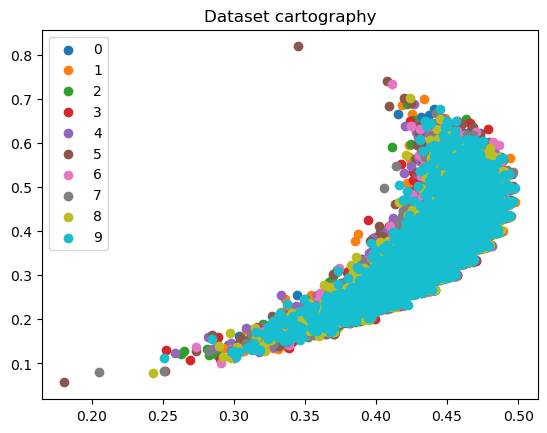

In [100]:
x = quality.std(axis=0)
y = quality.mean(axis=0)
for i in range(10):
    indxs = [v == i for v in train_dataset.targets]
    plt.scatter(x[indxs], y[indxs], label=i)
# plt.scatter(x, y)
plt.title("Dataset cartography")
plt.legend()
plt.show()

## Clusterisation idea
**That's "TODO" part for now**

The idea is that the model can tell us something about the difficulty even without training. Layers just change the basis of input. We can try to randomly initialize the model several times and look at the changes of some metric. Probably if we cluster the latents, difficult samples will run from one cluster to another.

Let's first use the results of the previous part - split the samples on 3 categories of difficulty

Until I find any reasonable way to authomize that we'll do it "by the eye"

In [25]:
from sklearn.decomposition import PCA

def clusterize(model, dataloader, difficulty):
    embeds = []
    with torch.no_grad():
        for x, _ in dataloader:
            embeds.append(model.latenter(x.to(device)))
    embeds = torch.vstack(embeds).detach().cpu().numpy()
    pca = PCA()
    embeds_sm = pca.fit_transform(embeds)
    for i in np.unique(difficulty):
        plt.plot(embeds_sm[difficulty == i, 0],
                 embeds_sm[difficulty == i, 1],
                 label=f"difficulty={i}")
    return embeds.numpy()
embeds = clusterize(model, dataloader, 1)


torch.Size([60000, 128])
